# Detecting heart arrythmias using anomaly detection
## Runar Helin

In [9]:
# import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from ipywidgets import interact

from plot_helpers import plot_confusion_matrix

%matplotlib notebook

## Let us prepare the dataset
This is a famous arrythmia dataset, the original task was to detect arrythmias. However, it has been modified so the task at hand is to detect a collection of very rare arrythmias instead.

In [3]:
linear_X = pd.read_csv('data/arrythmia_linear.csv', index_col=0)
nominal_X = pd.read_csv('data/arrythmia_nominal.csv', index_col=0)
y = pd.read_csv('data/arrythmia_targets.csv', index_col=0, header=None)

In [4]:
train_linear_X, test_linear_X, train_nominal_X, test_nominal_X, train_y, test_y = train_test_split(
    linear_X,
    nominal_X,
    y,
    test_size=0.50,
    random_state=42
)

In [5]:
test_linear_X.head()

,Age: Age in years,Height: Height in centimeters,Weight: Weight in kilograms,QRS duration: Average of QRS duration in msec.,P-R interval: Average duration between onset of P and Q waves in msec.,Q-T interval: Average duration between onset of Q and offset of T waves in msec.,T interval: Average duration of T wave in msec.,P interval: Average duration of P wave in msec.,Heart rate: Number of heart beats per minute,"Q wave - Average width, in msec (DI)",...,QRSTA = QRSA + 0.5 * width of T wave * 0.1 * height of T wave. (If T is diphasic then the bigger segment is considered) (V5),"JJ wave - Amplitude , * 0.1 milivolt (V6)","Q wave - Amplitude , * 0.1 milivolt (V6)","R wave - Amplitude , * 0.1 milivolt (V6)","S wave - Amplitude , * 0.1 milivolt (V6)","R' wave - Amplitude , * 0.1 milivolt (V6)","P wave - Amplitude , * 0.1 milivolt (V6)","T wave - Amplitude , * 0.1 milivolt (V6)","QRSA , Sum of areas of all segments divided by 10, ( Area= width * height / 2 ) (V6)",QRSTA = QRSA + 0.5 * width of T wave * 0.1 * height of T wave. (If T is diphasic then the bigger segment is considered) (V6)
299,51.0,170.0,82.0,90.0,155.0,382.0,216.0,88.0,9.0,24.0,...,59.9,-0.1,0.0,10.7,-0.9,0.0,0.4,2.6,23.7,47.6
39,45.0,175.0,80.0,94.0,163.0,401.0,159.0,106.0,-57.0,0.0,...,30.4,-0.4,0.0,3.1,0.0,0.0,0.4,1.0,10.5,17.9
336,31.0,165.0,56.0,74.0,199.0,384.0,142.0,100.0,110.0,44.0,...,32.4,0.1,0.0,4.2,-0.6,0.0,0.6,0.9,9.6,14.4
332,42.0,188.0,91.0,113.0,213.0,358.0,220.0,107.0,91.0,0.0,...,68.5,0.1,-0.5,11.2,-1.3,0.0,1.0,2.5,22.1,47.6
153,34.0,167.0,60.0,63.0,164.0,396.0,139.0,84.0,49.0,0.0,...,46.8,-0.1,0.0,8.7,0.0,0.0,0.4,1.5,22.6,33.4


In [6]:
train_y.iloc[:, 0].value_counts() / len(train_y)

0    0.849558
1    0.150442
Name: 1, dtype: float64

## Let us explore the dataset
First, what is the contamination rate? That is, what is the outlier rate of this dataset?

In [7]:
print(f'The contamination rate is {train_y.mean().iloc[0]:.2f}')

The contamination rate is 0.15


Let us now visualise our dataset, using an interactive matplotlib plot. 

PS. sometimes, it takes several attemts at `%matplotlib notebook` for it to work

<IPython.core.display.Javascript object>


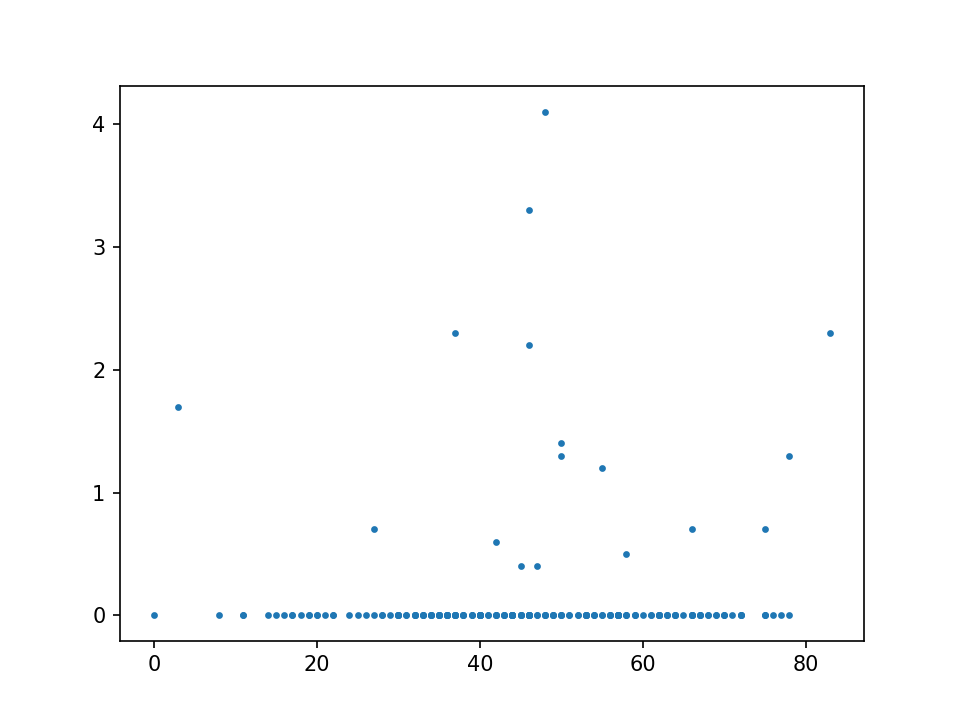

interactive(children=(Dropdown(description='x_col', options=('Age: Age in years ', 'Height: Height in centimet…

In [10]:
fig = plt.figure()
sub = plt.subplot()

@interact(x_col=train_linear_X.columns, y_col=train_linear_X.columns)
def replot(x_col, y_col):
    sub.clear()
    sub.scatter(train_linear_X[x_col], train_linear_X[y_col], s=5)

From this, we see that there are many missing values that are set to zero. This is not ideal for the case at hand and will make it more difficult for us to find outliers (there will probably be a fair amount of false positives as well)

## Let us save some lives!

In [11]:
scaler = StandardScaler()
train_linear_X = scaler.fit_transform(train_linear_X)
test_linear_X = scaler.transform(test_linear_X)

#train_X = pd.concat([train_linear_X, train_nominal_X], axis=1)
#test_X = pd.concat([test_linear_X, test_nominal_X], axis=1)

train_X = np.hstack([train_linear_X, train_nominal_X.values])
test_X = np.hstack([test_linear_X, test_nominal_X.values])

## Local Outlier Factor

In [24]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.15)
train_lof_prediction = lof.fit_predict(train_X)
#test_lof_prediction = lof._predict(test_X)    # Error in sklearn API so predict is missing...

lof_novelty = LocalOutlierFactor(n_neighbors=20, contamination=0.15, novelty=True)
lof_novelty.fit(train_X)
test_lof_prediction = lof_novelty.predict(test_X)

### Plotting confusion matrix to assess results

In [25]:
train_lof_cm = metrics.confusion_matrix(1 - 2*train_y, train_lof_prediction)
test_lof_cm = metrics.confusion_matrix(1 - 2*test_y, test_lof_prediction)

<IPython.core.display.Javascript object>


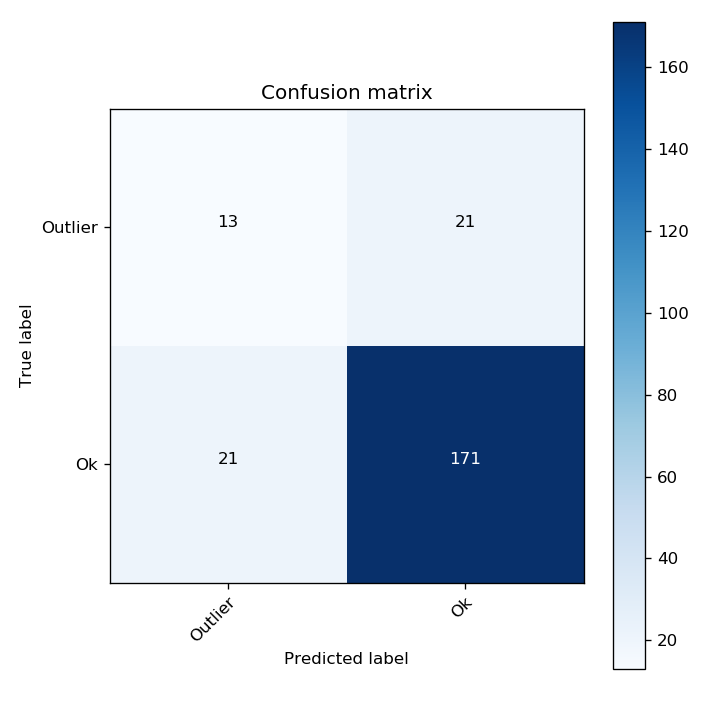

In [26]:
plot_confusion_matrix(train_lof_cm, ['Outlier', 'Ok'])

<IPython.core.display.Javascript object>


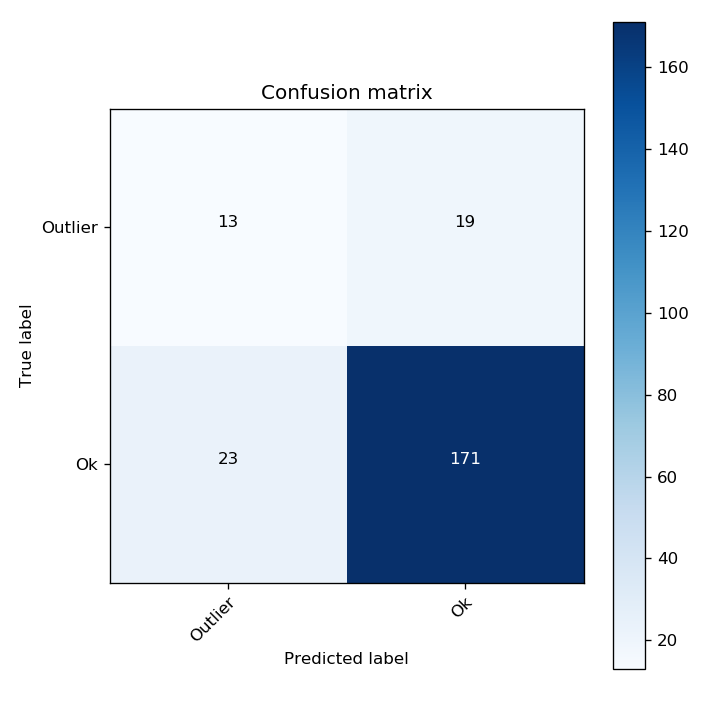

In [27]:
plot_confusion_matrix(test_lof_cm, ['Outlier', 'Ok'])

### Conclusion from Local Outlier Factor
LOF worked well on the training data, but not the test set. This is strange as it is an unsupervised method and indicates that we do not have enough training data.

## Isolation Forest

In [28]:
iforest = IsolationForest(contamination=0.15, behaviour='new')
iforest.fit(train_X)

train_if_prediction = iforest.predict(train_X)
test_if_prediction = iforest.predict(test_X)

In [29]:
train_if_cm = metrics.confusion_matrix(1 - 2*train_y, train_if_prediction)
test_if_cm = metrics.confusion_matrix(1 - 2*test_y, test_if_prediction)

<IPython.core.display.Javascript object>


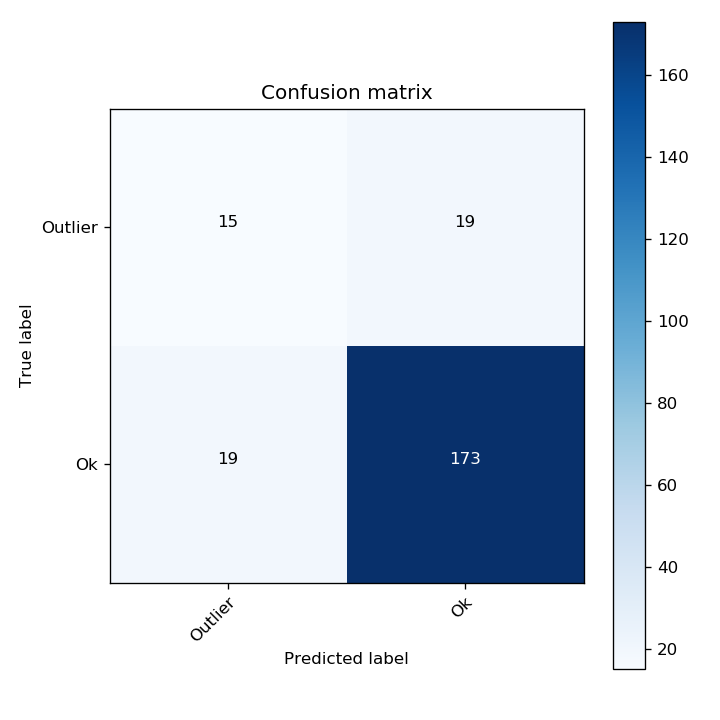

In [30]:
plot_confusion_matrix(train_if_cm, ['Outlier', 'Ok'])

<IPython.core.display.Javascript object>


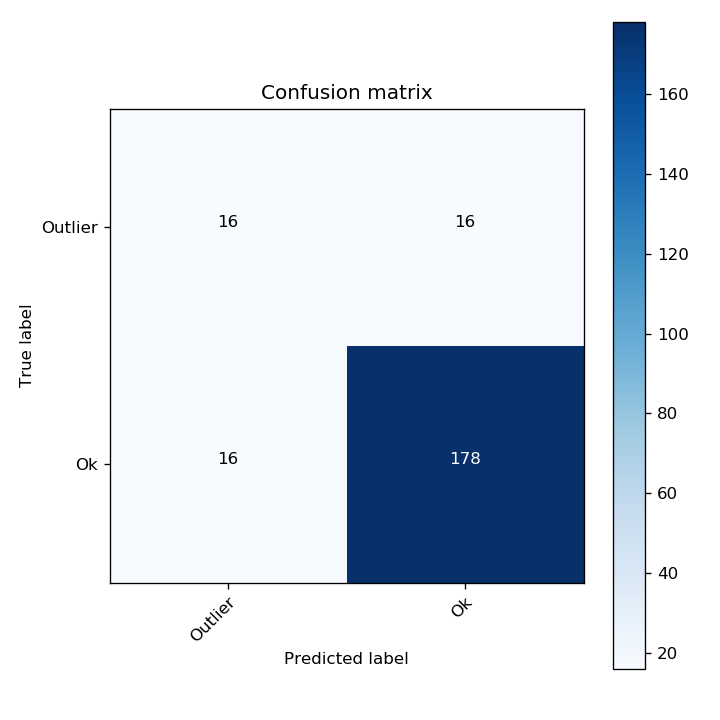

In [31]:
plot_confusion_matrix(test_if_cm, ['Outlier', 'Ok'])